# Import libraries

In [1]:
import matplotlib.pyplot as plt 
from plotnine import *
import pandas as pd
import numpy as np
import scipy

import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels

pd.set_option("mode.chained_assignment",None)


# Load data

In [45]:
data_filepath = r"input_data/epicea_data.csv"
patients_df = pd.read_csv(data_filepath)
patients_df.head()

,Nom,Num,Age,sexe,PharmacoRes,PMAs,EME_DE_NOVO,Duree_EME_min,STESS,EMSE,Ranking_score,Ranking_time
0,SA,1,79,1,1,1,1,7000,6,111,2,pre-EME
1,QD,2,80,1,1,0,1,7200,4,110,2,pre-EME
2,VA,3,59,0,1,0,1,20,3,82,4,pre-EME
3,AC,4,69,0,0,0,1,100,4,79,3,pre-EME
4,PA,5,75,1,0,1,1,40,3,25,0,pre-EME


# Reorder data

In [46]:
### Corrige avec .loc

patients_df.loc[patients_df['EME_DE_NOVO'] == 0, 'EME_DE_NOVO'] = "NISE"
patients_df.loc[patients_df['EME_DE_NOVO'] == 1, 'EME_DE_NOVO'] = "NOSE"

patients_df.loc[patients_df['PMAs'] == 0, 'PMAs'] = "noPMA"
patients_df.loc[patients_df['PMAs'] == 1, 'PMAs'] = "PMA"

patients_df.loc[patients_df['PharmacoRes'] == 0, 'PharmacoRes'] = "noPR"
patients_df.loc[patients_df['PharmacoRes'] == 1, 'PharmacoRes'] = "PR"

patients_df.loc[patients_df['Ranking_time'] == "pre-EME", 'Ranking_time'] = np.int64(0) #"1. pre-EME"
patients_df.loc[patients_df['Ranking_time'] == "M1", 'Ranking_time'] = np.int64(1) #"2. M1"
patients_df.loc[patients_df['Ranking_time'] == "M3", 'Ranking_time'] = np.int64(2) #"3. M3"
patients_df.loc[patients_df['Ranking_time'] == "M12", 'Ranking_time'] = np.int64(3) #"4. M12"

patients_df.loc[patients_df['EME_DE_NOVO'] == 0, 'EME_DE_NOVO'] = "NISE"
patients_df.loc[patients_df['EME_DE_NOVO'] == 1, 'EME_DE_NOVO'] = "NOSE"

patients_df.head()

/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/801416887.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NISE' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/801416887.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'noPMA' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/801416887.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'noPR' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,Nom,Num,Age,sexe,PharmacoRes,PMAs,EME_DE_NOVO,Duree_EME_min,STESS,EMSE,Ranking_score,Ranking_time
0,SA,1,79,1,PR,PMA,NOSE,7000,6,111,2,0
1,QD,2,80,1,PR,noPMA,NOSE,7200,4,110,2,0
2,VA,3,59,0,PR,noPMA,NOSE,20,3,82,4,0
3,AC,4,69,0,noPR,noPMA,NOSE,100,4,79,3,0
4,PA,5,75,1,noPR,PMA,NOSE,40,3,25,0,0


# Show dependant variable (Ranking_score)
## Histogram

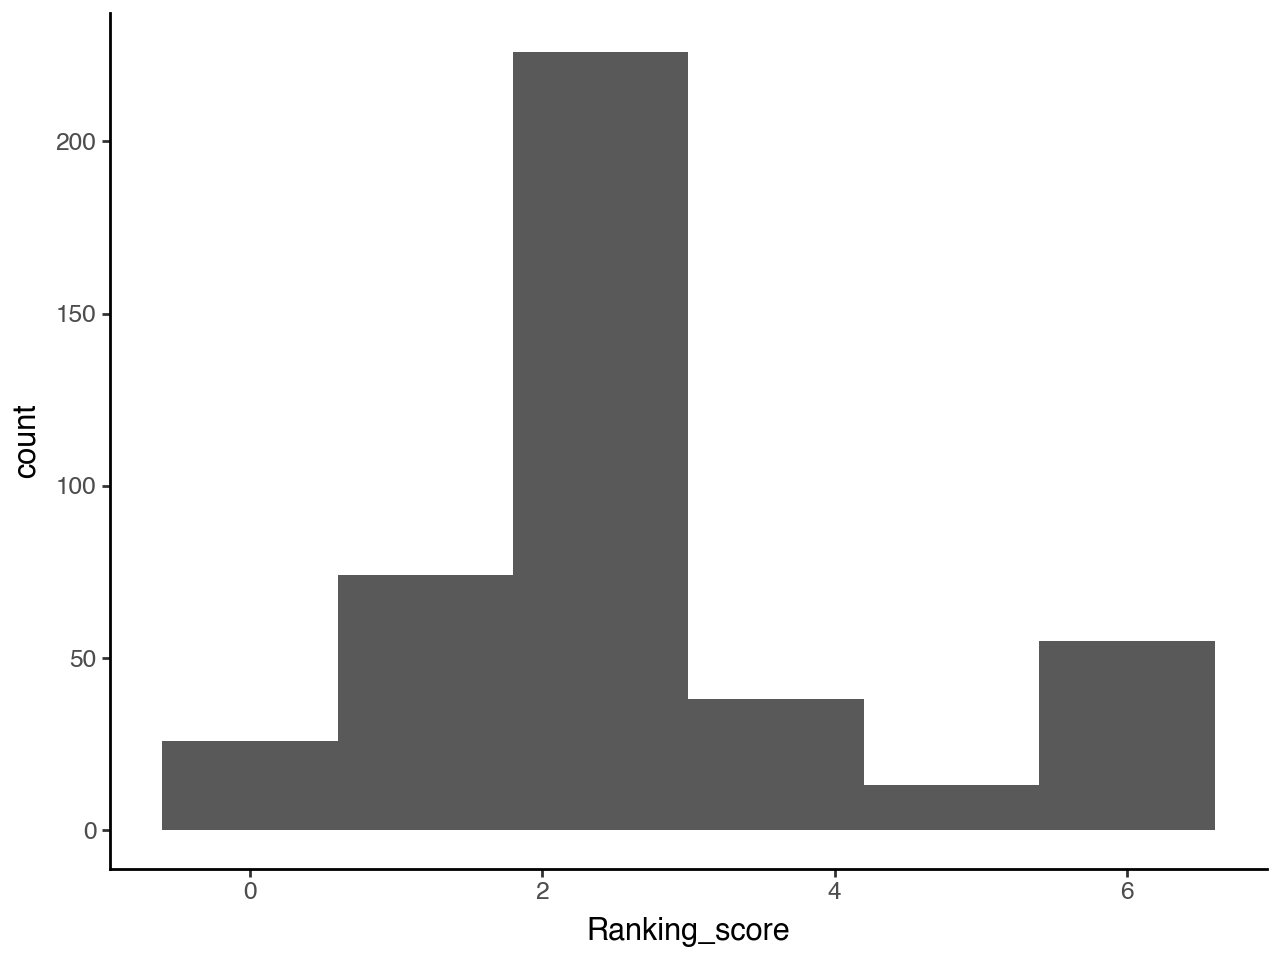

In [48]:
hist_1 = (ggplot(patients_df)
    + aes(x='Ranking_score')
    + geom_histogram(bins=6)          
    + theme_classic()          
    )

hist_1

## QQPlot

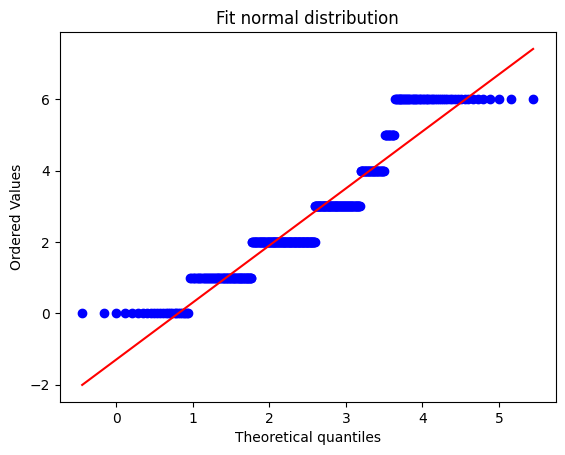

In [49]:
stats.probplot(patients_df['Ranking_score'], dist='norm', sparams=(2.5,), plot=plt)
plt.title("Fit normal distribution")
plt.show()

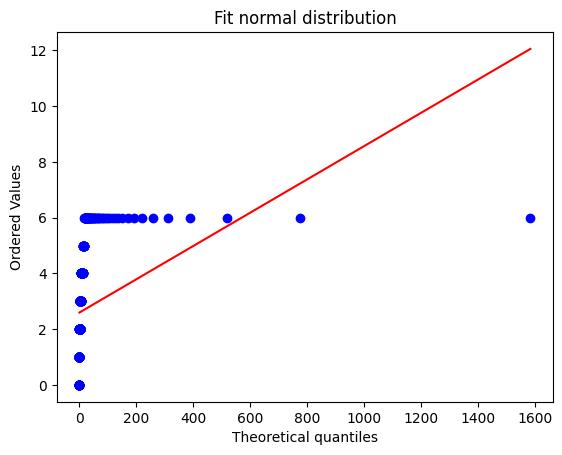

In [50]:
stats.probplot(patients_df['Ranking_score'], dist='lognorm', sparams=(2.5,), plot=plt)
plt.title("Fit normal distribution")
plt.show()

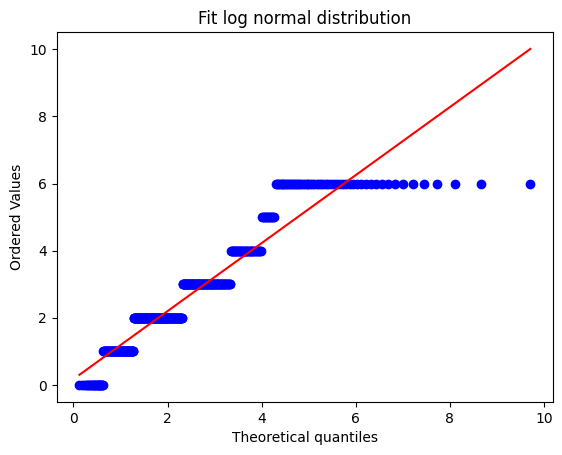

In [51]:
stats.probplot(patients_df['Ranking_score'], dist='gamma', sparams=(2.5,), plot=plt)
plt.title("Fit log normal distribution")
plt.show()

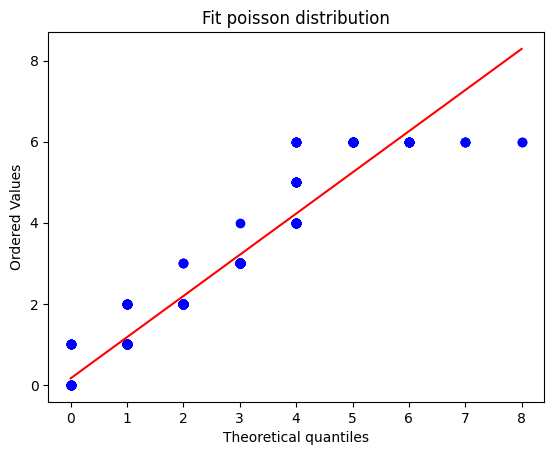

In [52]:
stats.probplot(patients_df['Ranking_score'], dist='poisson', sparams=(2.5,), plot=plt)
plt.title("Fit poisson distribution")
plt.show()

# 1. NISE vs NOSE
## 1.1. Boxplots

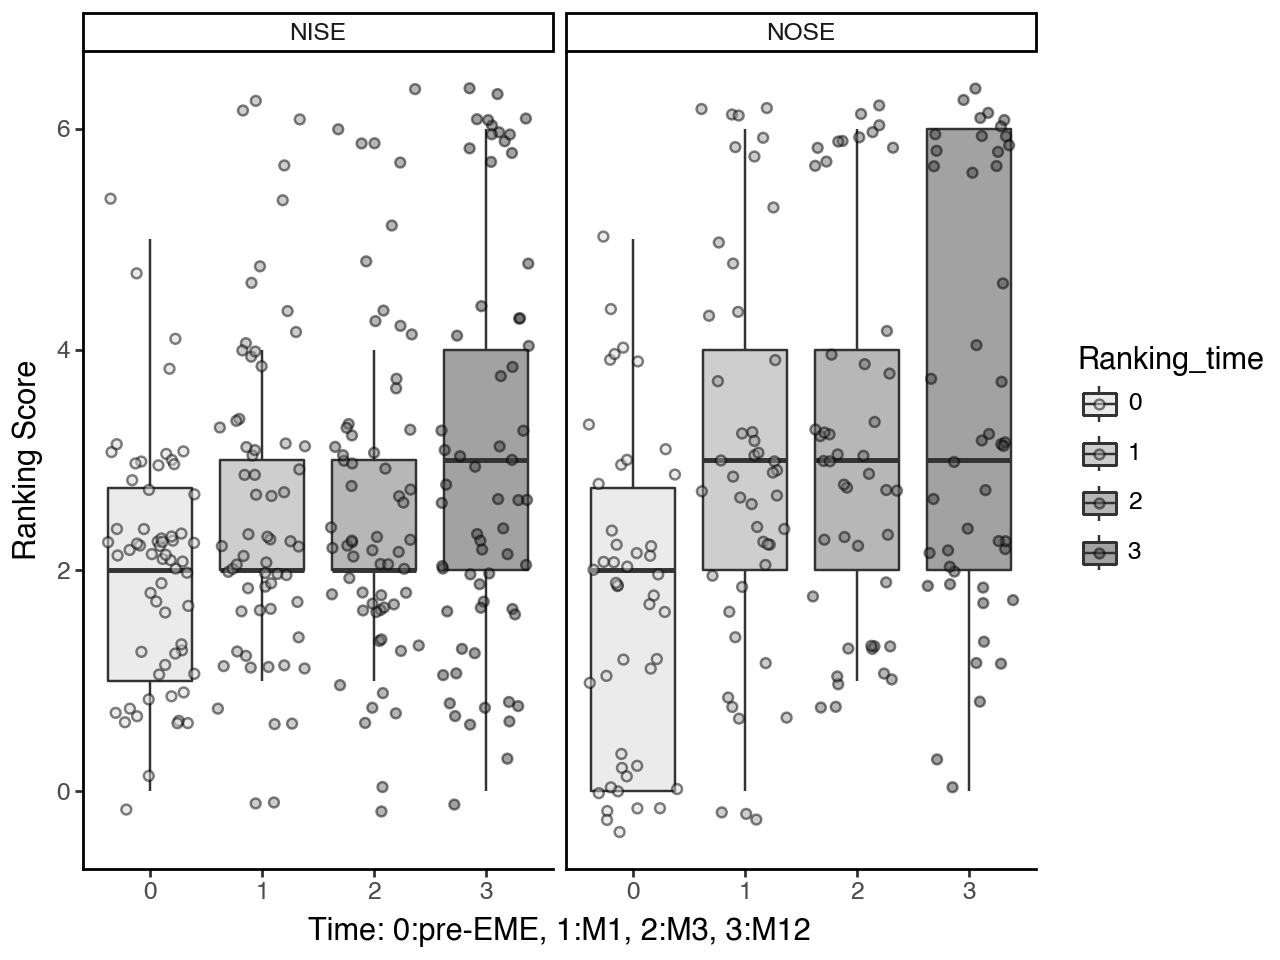

In [53]:
cols = ["#d9d9d9","#9e9e9e","#707070","#474747"]

boxplot_1 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('EME_DE_NOVO', ncol = 2)
    + scale_fill_manual(values=cols)             
    )

boxplot_1

## 1.2. Linear regressions

/Users/gardy/Documents/GardyL/Dev_projects/_Github_repositories/epicea_epilepsy/.venv/lib/python3.11/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


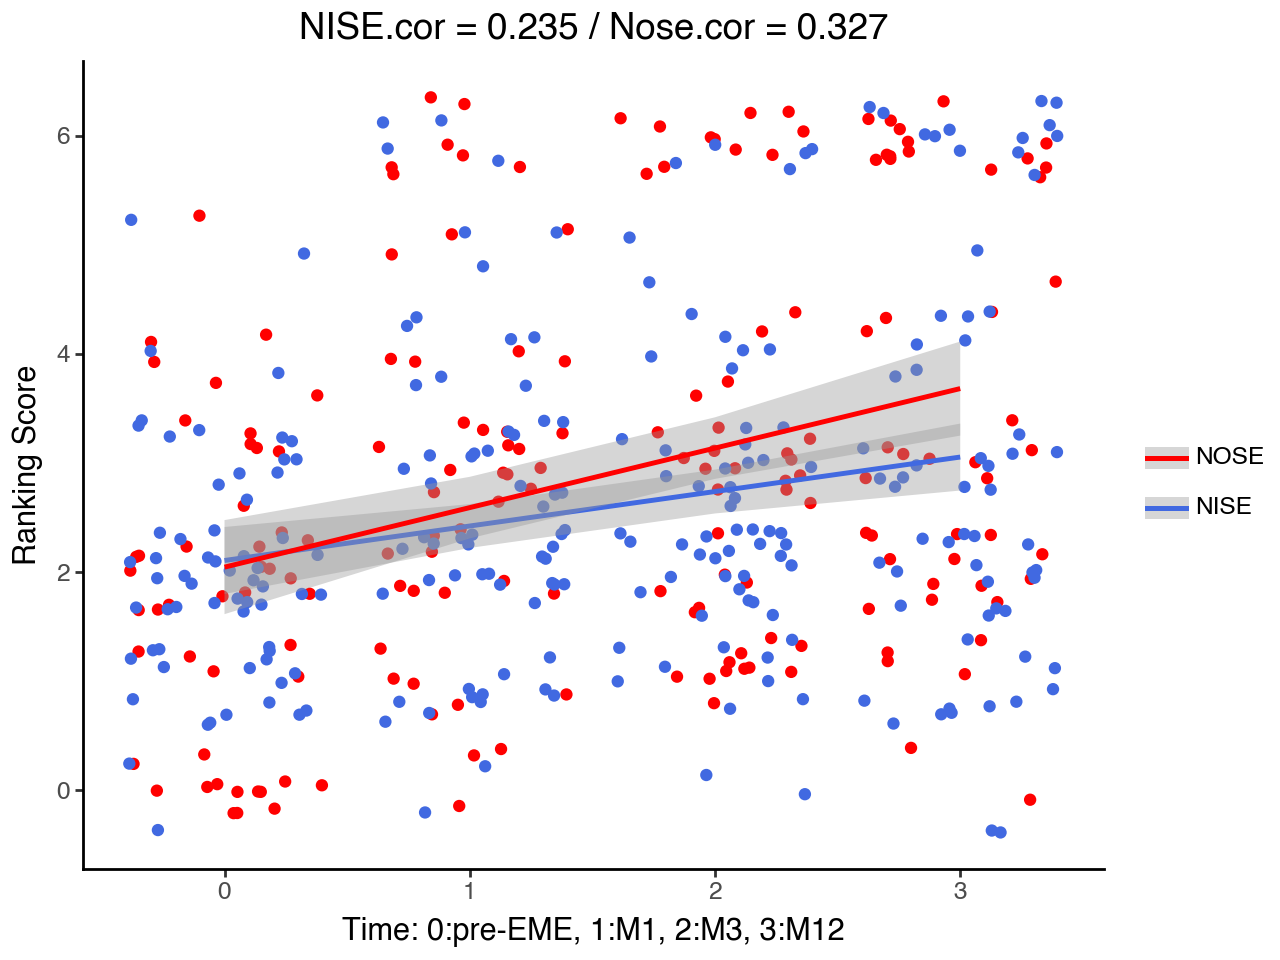

In [54]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['EME_DE_NOVO'])
z_col = np.array(list(z)).astype('<U64')
z_col[z_col == "NOSE"] = "red"
z_col[z_col == "NISE"] = "royalblue"

### Calculate Pearson correlations
r_NISE = np.round(np.corrcoef(x[z=="NISE"], y[z=="NISE"])[0,1],3)
r_NOSE = np.round(np.corrcoef(x[z=="NOSE"], y[z=="NOSE"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter(color=z_col)
    + geom_smooth(method='lm')
    + scale_colour_manual(values=["red", "royalblue"], limits=["NOSE", "NISE"])
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'NISE.cor = {r_NISE} / Nose.cor = {r_NOSE}')             
    + theme_classic()          
    )

lreg_1

## 1.3. Mixed effects model

In [55]:
md = smf.mixedlm("Ranking_score ~ EME_DE_NOVO + Ranking_time + EME_DE_NOVO:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                          Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           Ranking_score
No. Observations:            432               Method:                       REML         
No. Groups:                  108               Scale:                        0.6706       
Min. group size:             4                 Log-Likelihood:               -665.5287    
Max. group size:             4                 Converged:                    Yes          
Mean group size:             4.0                                                          
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        2.016    0.203  9.936 0.000  1.618  2.414
EME_DE_NOVO[T.NOSE]       

<span style="color:red;font-weight:400;font-size:14px">
There is no global effect of being NOSE vs being NISE. Nevertheless, there is an interaction between EME_DE_NOVO (NOSE/NISE) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
<span>

### Patients NISE
- Patients NISE have an average ranking of 2.016 at time "pre-EME". _**`Total: 2.016`**_
- Patients NISE have an average ranking of 2.016 + 0.597 at time "M1". _**`Total: 2.613`**_ 
- Patients NISE have an average ranking of 2.016 + 0.613 at time "M3". _**`Total: 2.629`**_
- Patients NISE have an average ranking of 2.016 + 1.048 at time "M12". _**`Total: 3.064`**_ 

### Patients NOSE
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) at time "pre-EME". _**`Total: 2.016`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 0.597  + 0.686 at time "M1". _**`Total: 3.299`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 0.613  + 0.844 at time "M3".  _**`Total: 3.473`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 1.048  + 0.712 at time "M12". _**`Total: 3.776`**_

As the intercept is not different between NISE and NOSE patients (p=0.373), its effect was removed from calculations (EME effect = 0.283-0.283 = 0).

### Let us plot the ranking slope over time for NISE and NOSE patients

/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/163134468.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


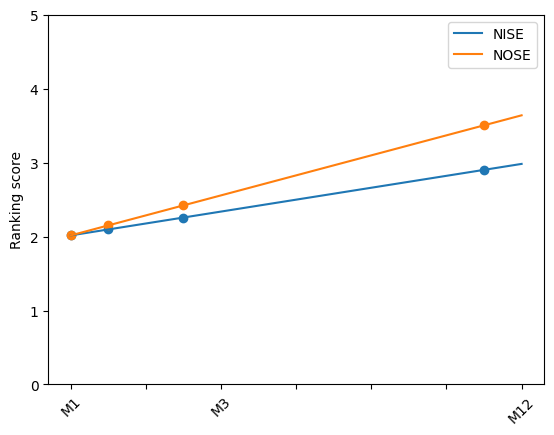

In [63]:
x_vals = np.arange(0,13)

intercept_NISE = 2.016
slope_NISE = (3.064-intercept_NISE) / 13 # 13 month between pre-EME and M12
#NISE_line = intercept_NISE + slope_NISE * x_vals
NISE_line = np.arange(intercept_NISE, intercept_NISE+slope_NISE*13, slope_NISE)

intercept_NOSE = 2.016 + (0.283-0.283)
slope_NOSE = (3.776-intercept_NOSE) / 13 # 13 month between pre-EME and M12
#NOSE_line  = intercept_NOSE + slope_NOSE * x_vals
NOSE_line = np.arange(intercept_NOSE, intercept_NOSE+slope_NOSE*13, slope_NOSE)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, NISE_line)
ax.plot(x_vals, NOSE_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [NISE_line[0], NISE_line[1], NISE_line[3], NISE_line[11]])
ax.scatter([0,1,3,11], [NOSE_line[0], NOSE_line[1], NOSE_line[3], NOSE_line[11]])
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "M12"],  rotation = 45)
ax.legend(["NISE","NOSE"])

## 1.4. Post-hoc
### Patients NISE

In [64]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["EME_DE_NOVO"]=="NISE"], patients_df["Ranking_time"][patients_df["EME_DE_NOVO"]=="NISE"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.5968,0.1096,-0.0853,1.2789,False
0,2,0.6129,0.0953,-0.0692,1.295,False
0,3,1.0484,0.0005,0.3663,1.7305,True
1,2,0.0161,0.9999,-0.666,0.6982,False
1,3,0.4516,0.3193,-0.2305,1.1337,False
2,3,0.4355,0.3518,-0.2466,1.1176,False


### Patients NOSE

In [65]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["EME_DE_NOVO"]=="NOSE"], patients_df["Ranking_time"][patients_df["EME_DE_NOVO"]=="NOSE"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.2826,0.0033,0.3318,2.2334,True
0,2,1.4565,0.0006,0.5057,2.4073,True
0,3,1.7609,0.0,0.81,2.7117,True
1,2,0.1739,0.9646,-0.7769,1.1247,False
1,3,0.4783,0.5614,-0.4726,1.4291,False
2,3,0.3043,0.8401,-0.6465,1.2552,False


### 1.4.1. Post-hoc results
<span style="color:red;font-weight:400;font-size:14px">
As the ranking_time has a different effect on NOSE and NISE patients, we analysed these two groups independantly.

- For NISE patients, ranking at pre-EME is different from ranking at M12 only (diff = 1.05; p adj. = 0.0005).
- For NOSE patients, ranking at pre-EME is different from ranking at M1 (diff = 1.28; p adj. = 0.0033), M3 (diff = 1.46; p adj. = 0.0006) and M12 (diff = 1.76; p adj. = 0).
<span>


# 2. With MRI anomaly (PMA) vs without MRI anomaly (noPMA)
## 2.1. Boxplots

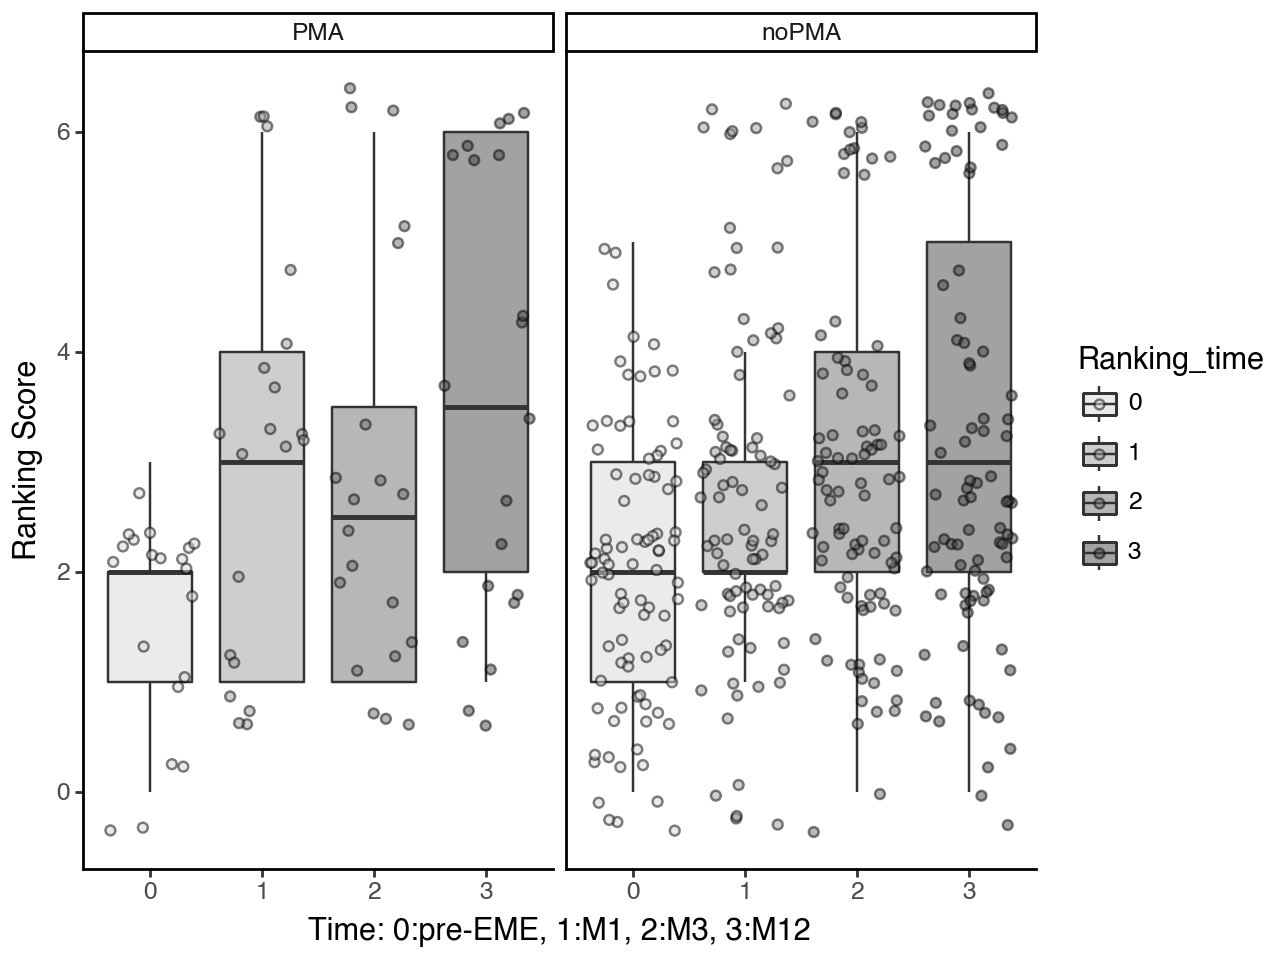

In [66]:
cols = ["#d9d9d9","#9e9e9e","#707070","#474747"]

boxplot_2 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('PMAs', ncol = 2)
    + scale_fill_manual(values=cols)
    )

boxplot_2

## 2.2. Linear regressions

/Users/gardy/Documents/GardyL/Dev_projects/_Github_repositories/epicea_epilepsy/.venv/lib/python3.11/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


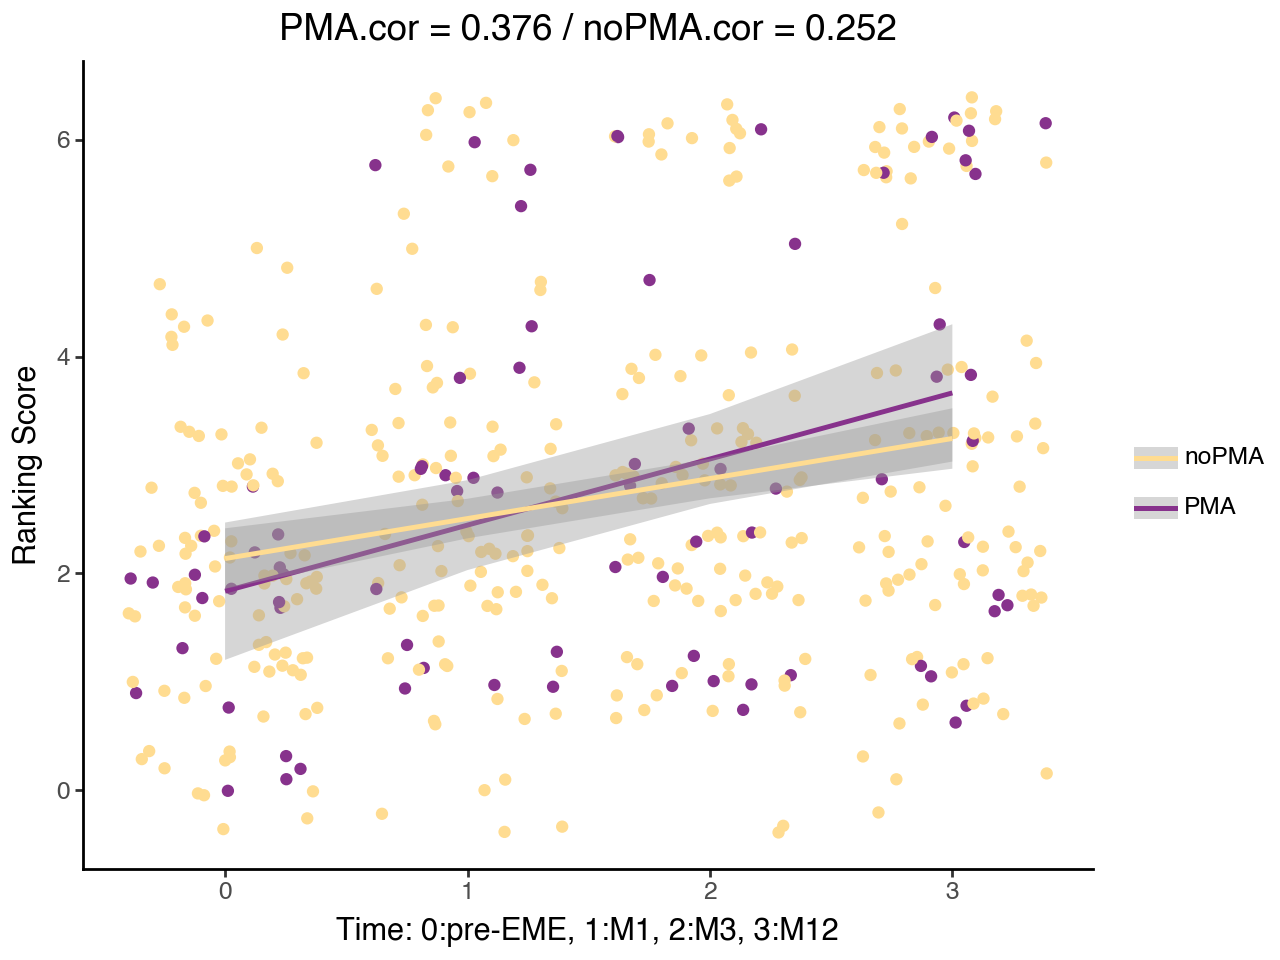

In [68]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['PMAs'])
z_col = np.array(list(z)).astype('<U64')
z_col[z_col == "noPMA"] = "#ffdc91"
z_col[z_col == "PMA"] = "#87328c"
          
### Calculate Pearson correlations
r_PMA = np.round(np.corrcoef(x[z=="PMA"], y[z=="PMA"])[0,1],3)
r_noPMA = np.round(np.corrcoef(x[z=="noPMA"], y[z=="noPMA"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter(color=z_col)
    + geom_smooth(method='lm')
    + scale_colour_manual(values=["#ffdc91", "#87328c"], limits=["noPMA", "PMA"])
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'PMA.cor = {r_PMA} / noPMA.cor = {r_noPMA}')
    + theme_classic()          
    )

lreg_1

## 2.3. Mixed effects model

In [69]:
md = smf.mixedlm("Ranking_score ~ PMAs + Ranking_time + PMAs:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                       Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Ranking_score
No. Observations:          432             Method:                     REML         
No. Groups:                108             Scale:                      0.6802       
Min. group size:           4               Log-Likelihood:             -667.3329    
Max. group size:           4               Converged:                  Yes          
Mean group size:           4.0                                                      
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  1.500    0.359  4.177 0.000  0.796  2.204
PMAs[T.noPMA]                              0.489    0.398  1.228 0.219 -0.291  1.268
Rank

<span style="color:green;font-weight:400;font-size:14px">
There is no global effect of being PMA vs being noPMA. Nevertheless, there is an interaction between PMAs (PMA/noPMA) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
</span>

### Patients PMA
- Patients PMA have an average ranking of 1.500 at time "pre-EME". _**`Total: 1.5`**_
- Patients PMA have an average ranking of 1.500 + 1.550 at time "M1". _**`Total: 3.1`**_ 
- Patients PMA have an average ranking of 1.500 + 1.350 at time "M3". _**`Total: 2.85`**_
- Patients PMA have an average ranking of 1.500 + 2.100 at time "M12". _**`Total: 3.6`**_ 

### Patients noPMA
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) at time "pre-EME". _**`Total: 1.5`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 1.550 - 0.811  at time "M1". _**`Total: 2.24`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 1.350 - (0.464+0.464)  at time "M3".  _**`Total: 2.85`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 2.100  - 0.918 at time "M12". _**`Total: 2.68`**_

As the intercept is not different between PMA and noPMA patients (p=0.219), its effect was removed from calculations (EME effect = 0.489-0.489 = 0).

### Let us plot the ranking slope over time for PMA and noPMA patients

/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/2050692247.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


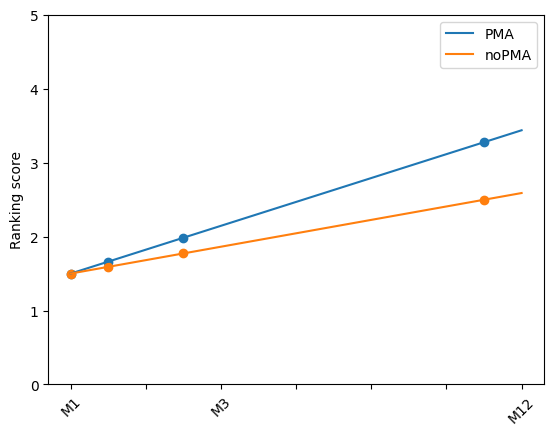

In [71]:
x_vals = np.arange(0,13)

intercept_PMA = 1.5
slope_PMA = (3.6-intercept_PMA) / 13 # 13 month between pre-EME and M12
PMA_line = np.arange(intercept_PMA, intercept_PMA+slope_PMA*13, slope_PMA)

intercept_noPMA = 1.5 + (-0.489+0.489)
slope_noPMA = (2.68-intercept_noPMA) / 13 # 13 month between pre-EME and M12
noPMA_line = np.arange(intercept_noPMA, intercept_noPMA+slope_noPMA*13, slope_noPMA)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, PMA_line)
ax.plot(x_vals, noPMA_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [PMA_line[0], PMA_line[1], PMA_line[3], PMA_line[11]])
ax.scatter([0,1,3,11], [noPMA_line[0], noPMA_line[1], noPMA_line[3], noPMA_line[11]])
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "M12"],  rotation = 45)
ax.legend(["PMA","noPMA"])

## 2.4. Post-hoc
### Patients PMA

In [72]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PMAs"]=="PMA"], patients_df["Ranking_time"][patients_df["PMAs"]=="PMA"], alpha=0.05)
tukeyHSD.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.55,0.0238,0.1519,2.9481,True
0,2,1.35,0.0623,-0.0481,2.7481,False
0,3,2.1,0.001,0.7019,3.4981,True
1,2,-0.2,0.9818,-1.5981,1.1981,False
1,3,0.55,0.7305,-0.8481,1.9481,False
2,3,0.75,0.4976,-0.6481,2.1481,False


### Patients noPMA

In [73]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PMAs"]=="noPMA"], patients_df["Ranking_time"][patients_df["PMAs"]=="noPMA"], alpha=0.05)
tukeyHSD.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.7386,0.0118,0.1203,1.357,True
0,2,0.8864,0.0014,0.268,1.5047,True
0,3,1.1818,0.0,0.5635,1.8002,True
1,2,0.1477,0.9267,-0.4706,0.7661,False
1,3,0.4432,0.2517,-0.1752,1.0615,False
2,3,0.2955,0.606,-0.3229,0.9138,False


### 2.4.1. Post-hoc results
<span style="color:green;font-weight:400;font-size:14px">
As the ranking_time has a different effect on PMA and noPMA patients, we analysed these two groups independantly.

- For PMA patients, ranking at pre-EME is different from ranking at M1 (diff = 1.55; p adj. = 0.024) and at M12 (diff = 2.1; p adj. = 0.001).
- For noPMA patients, ranking at pre-EME is different from ranking at M1 (diff = 0.73; p adj. = 0.01), M3 (diff = 0.89; p adj. = 0.001) and M12 (diff = 1.18; p adj. = 0).
<span>


# 3. Pharmacoresistant (PR) vs not pharmacoresistant (noPR)
## 3.1. Boxplots

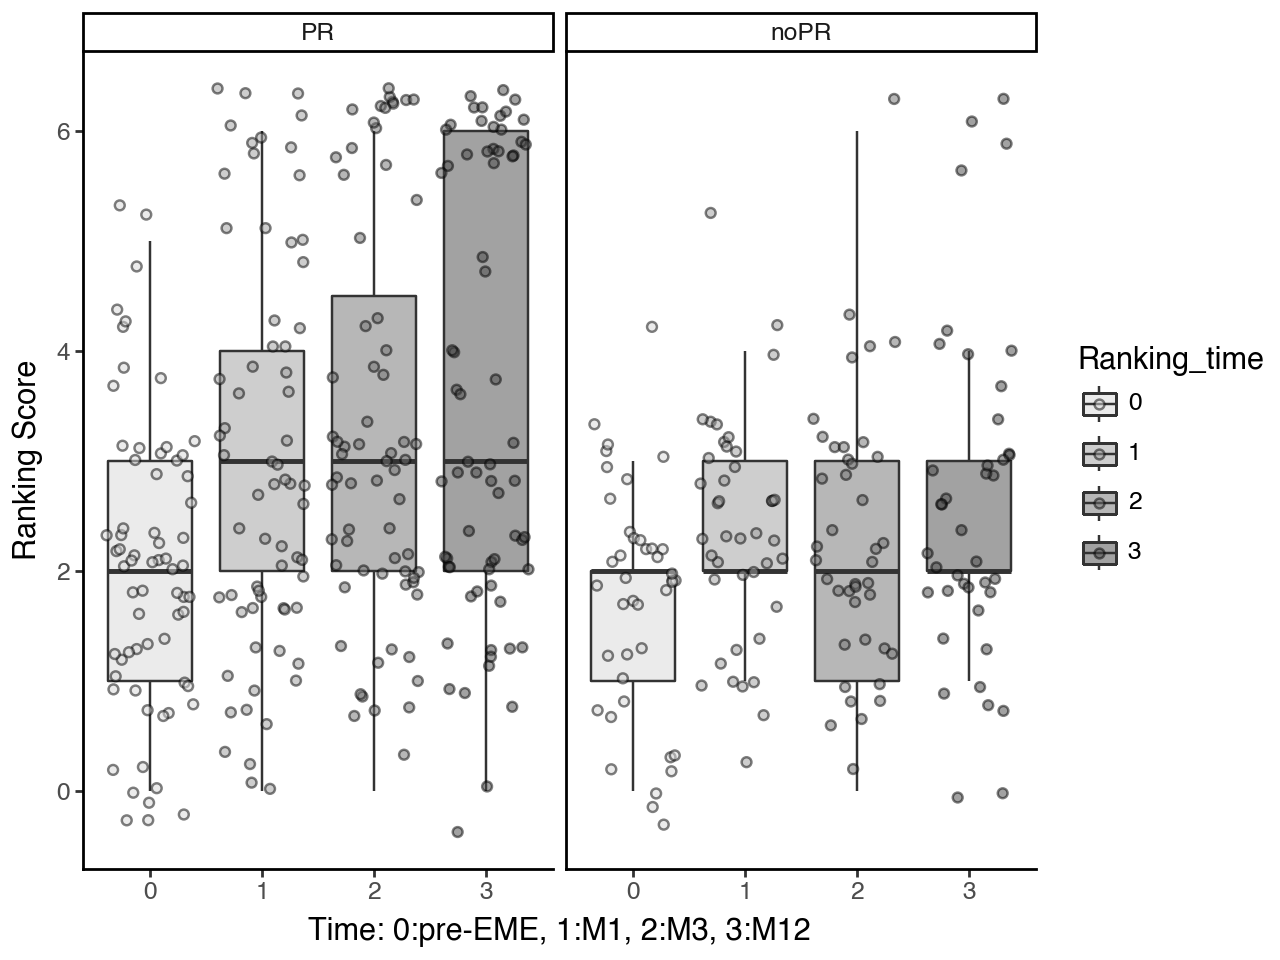

In [74]:
cols = ["#d9d9d9","#9e9e9e","#707070","#474747"]

boxplot_3 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('PharmacoRes', ncol = 2)
    + scale_fill_manual(values=cols)             
    )

boxplot_3

## 3.2. Linear regressions

/Users/gardy/Documents/GardyL/Dev_projects/_Github_repositories/epicea_epilepsy/.venv/lib/python3.11/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


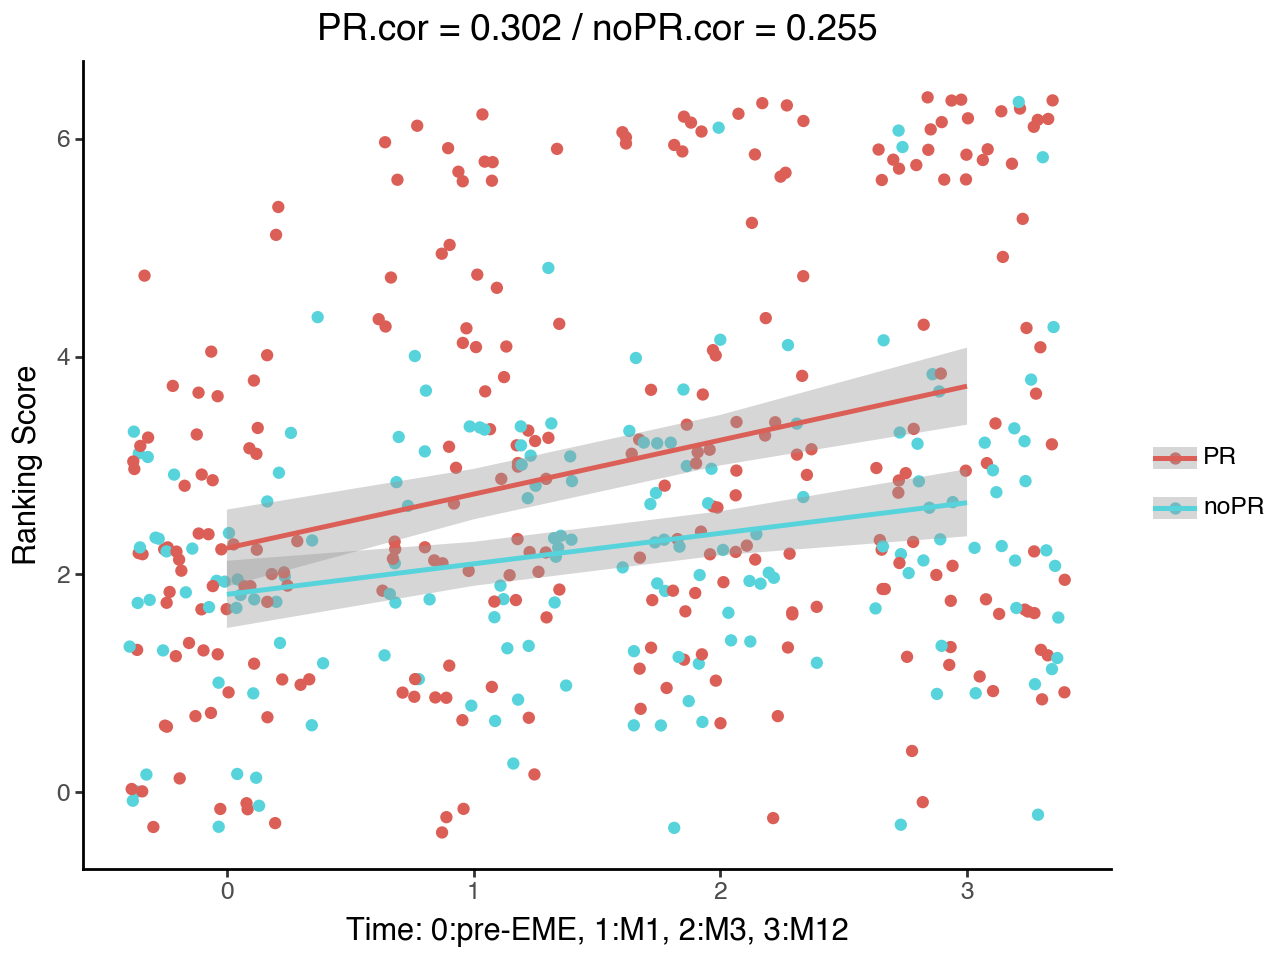

In [75]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['PharmacoRes'])

### Calculate Pearson correlations
r_PR = np.round(np.corrcoef(x[z=="PR"], y[z=="PR"])[0,1],3)
r_noPR = np.round(np.corrcoef(x[z=="noPR"], y[z=="noPR"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'PR.cor = {r_PR} / noPR.cor = {r_noPR}')             
    + theme_classic()          
    )

lreg_1

## 3.3. Mixed effect model

In [76]:
md = smf.mixedlm("Ranking_score ~ PharmacoRes + Ranking_time + PharmacoRes:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                          Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           Ranking_score
No. Observations:            432               Method:                       REML         
No. Groups:                  108               Scale:                        0.6837       
Min. group size:             4                 Log-Likelihood:               -665.5012    
Max. group size:             4                 Converged:                    Yes          
Mean group size:             4.0                                                          
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        2.015    0.191 10.539 0.000  1.640  2.390
PharmacoRes[T.noPR]       

<span style="color:blue;font-weight:400;font-size:14px">
There is no global effect of being PR vs being noPR. Nevertheless, there is an interaction between PRs (PR/noPR) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
</span>

### Patients PR
- Patients PMA have an average ranking of 2.015 at time "pre-EME". _**`Total: 2.015`**_
- Patients PMA have an average ranking of 2.015 + 1.060 at time "M1". _**`Total: 3.08`**_ 
- Patients PMA have an average ranking of 2.015 + 1.224 at time "M3". _**`Total: 3.24`**_
- Patients PMA have an average ranking of 2.015 + 1.597 at time "M12". _**`Total: 3.6`**_ 

### Patients noPR
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) at time "pre-EME". _**`Total: 2.015`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.060 - (0.450+0.450)  at time "M1". _**`Total: 3.08`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.224 - 0.663  at time "M3".  _**`Total: 2.58`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.597  - 0.646 at time "M12". _**`Total: 2.97`**_

As the intercept is not different between PMA and noPMA patients (p=0.322), its effect was removed from calculations (EME effect = 0.308-0.308 = 0).

### Let us plot the ranking slope over time for PMA and noPMA patients

/var/folders/wr/4qkbvx5x3973zr9frfjcjhnm0000gp/T/ipykernel_40722/1910963526.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


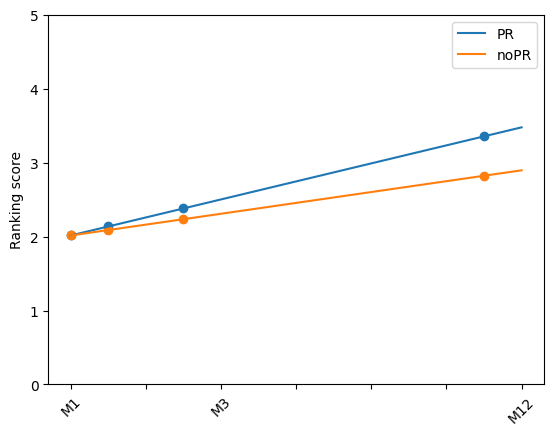

In [79]:
x_vals = np.arange(0,13)

intercept_PR = 2.015
slope_PR = (3.6-intercept_PR) / 13 # 13 month between pre-EME and M12
PR_line = np.arange(intercept_PR, intercept_PR+slope_PR*13, slope_PR)

intercept_noPR = 2.015 + (-0.450+0.450)
slope_noPR = (2.97-intercept_noPR) / 13 # 13 month between pre-EME and M12
noPR_line = np.arange(intercept_noPR, intercept_noPR+slope_noPR*13, slope_noPR)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, PR_line)
ax.plot(x_vals, noPR_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [PR_line[0], PR_line[1], PR_line[3], PR_line[11]])
ax.scatter([0,1,3,11], [noPR_line[0], noPR_line[1], noPR_line[3], noPR_line[11]])
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "M12"],  rotation = 45)
ax.legend(["PR","noPR"])

## 3.4. Post-hoc
### Patients PR

In [80]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PharmacoRes"]=="PR"], patients_df["Ranking_time"][patients_df["PharmacoRes"]=="PR"], alpha=0.05)
tukeyHSD.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.0597,0.003,0.2774,1.842,True
0,2,1.2239,0.0004,0.4416,2.0062,True
0,3,1.597,0.0,0.8147,2.3793,True
1,2,0.1642,0.9485,-0.6181,0.9465,False
1,3,0.5373,0.2873,-0.245,1.3196,False
2,3,0.3731,0.6063,-0.4092,1.1554,False


### Patients noPR

In [81]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PharmacoRes"]=="noPR"], patients_df["Ranking_time"][patients_df["PharmacoRes"]=="noPR"], alpha=0.05)
tukeyHSD.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.6098,0.1001,-0.0757,1.2952,False
0,2,0.561,0.1497,-0.1245,1.2464,False
0,3,0.9512,0.0024,0.2658,1.6367,True
1,2,-0.0488,0.9978,-0.7342,0.6367,False
1,3,0.3415,0.5685,-0.344,1.0269,False
2,3,0.3902,0.4531,-0.2952,1.0757,False


### 3.4.1. Post-hoc results
<span style="color:blue;font-weight:400;font-size:14px">
As the ranking_time has a different effect on PR and noPR patients, we analysed these two groups independantly.

- For PR patients, ranking at pre-EME is different from ranking at M1 (diff = 1.06; p adj. = 0.003), M3 (diff = 1.24; p adj. = 0.0004) and M12 (diff = 1.6; p adj. = 0).
- For noPR patients, ranking at pre-EME is different from ranking at M12 only (diff = 0.95; p adj. = 0.002).
<span>


# 4. Correlations

## 4.1. Ranking_score  at M12 vs EME_duration_min
Data with an EME_duration above 50000 min were removed from dataset (n = 4 values = 1 patient).

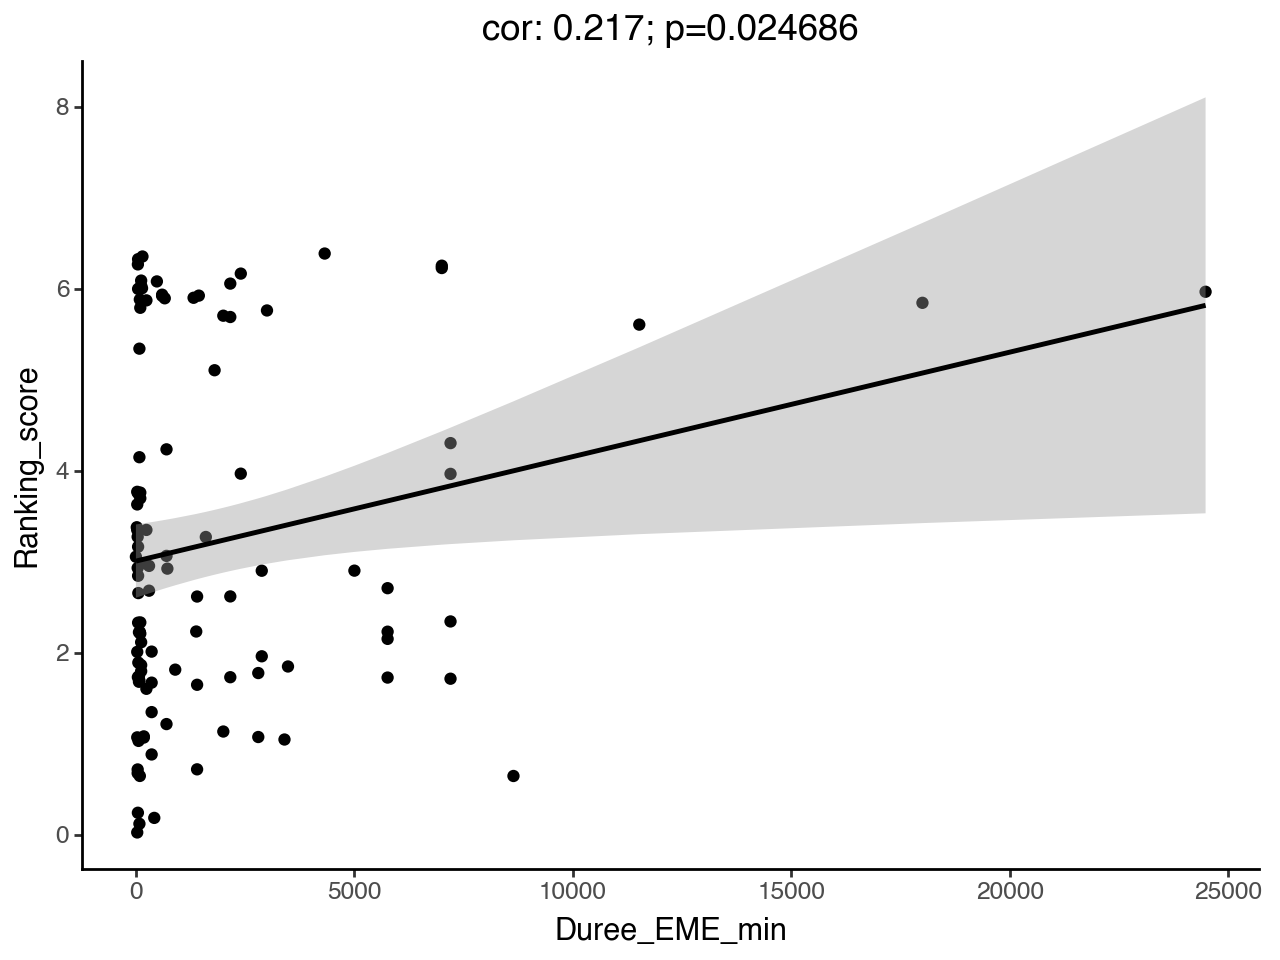

In [82]:
### Calculate Pearson correlations
x = patients_df['Duree_EME_min'][(patients_df['Duree_EME_min'] < 50000) & (patients_df['Ranking_time']==3)]
y = patients_df['Ranking_score'][(patients_df['Duree_EME_min'] < 50000) & (patients_df['Ranking_time']==3)]
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1

## 4.2. Ranking_score  at M12 vs EMSE

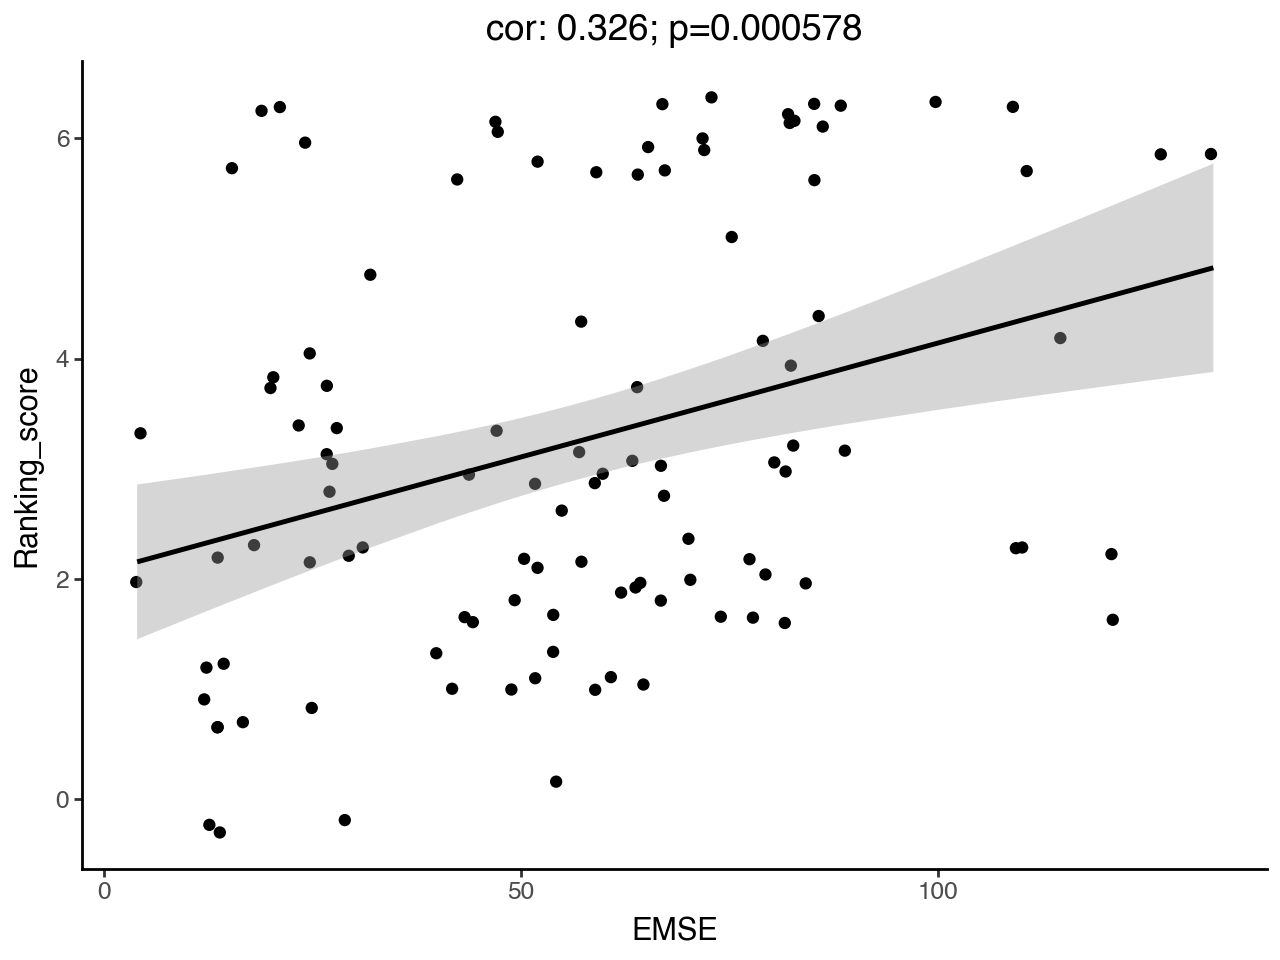

In [83]:
### Calculate Pearson correlations
x = patients_df['EMSE'][patients_df['Ranking_time']==3]
y = patients_df['Ranking_score'][patients_df['Ranking_time']==3]
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1

## 4.3. Ranking_score at M12 vs STESS

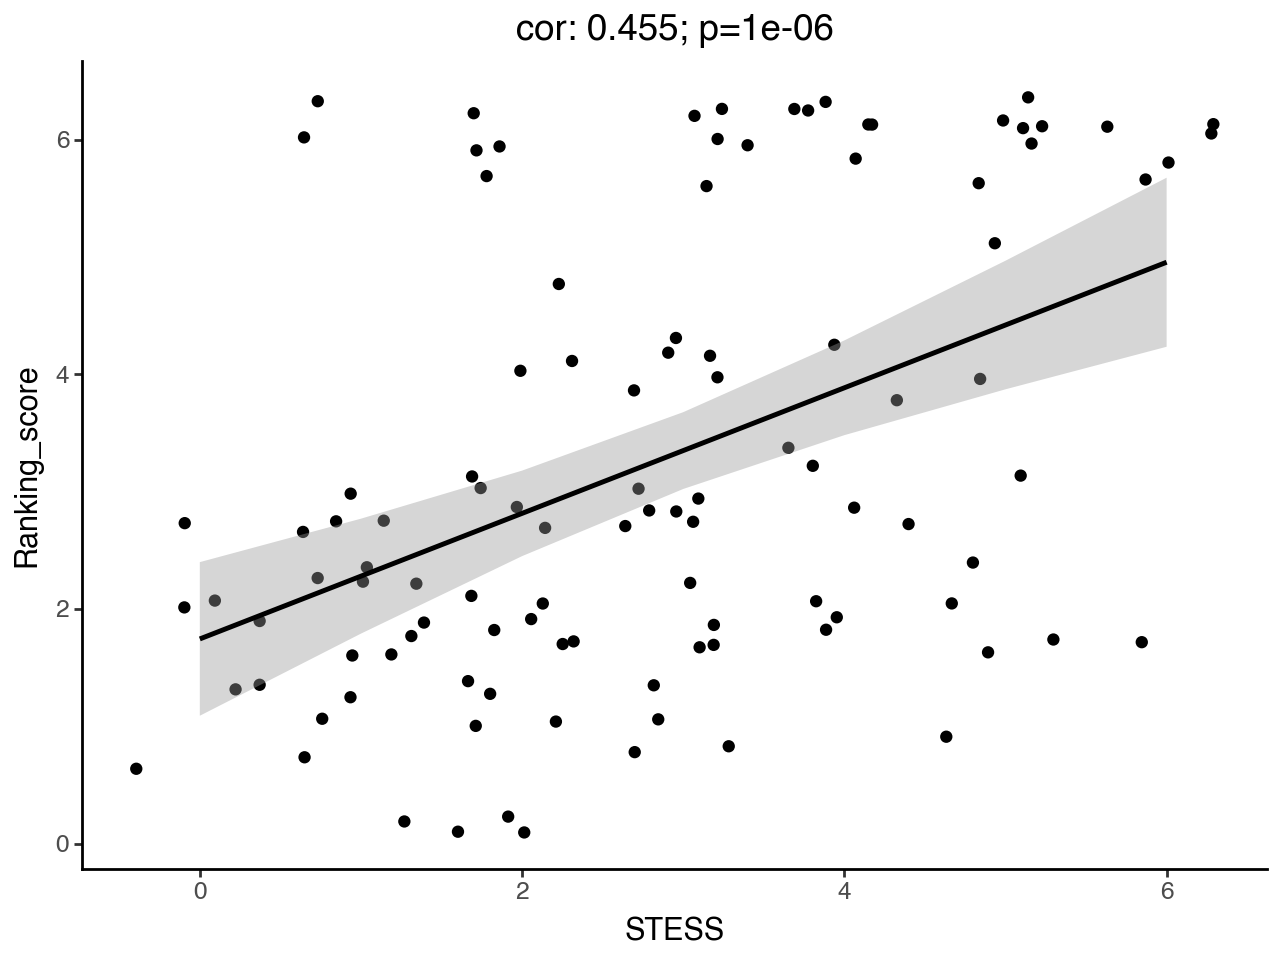

In [84]:
### Calculate Pearson correlations
x = patients_df['STESS'][patients_df['Ranking_time']==3]
y = patients_df['Ranking_score'][patients_df['Ranking_time']==3]
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1